In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
batchSize= 32
imgSize= 224
rgbChannels= 3
EPOCHS= 100

In [3]:
datasets= tf.keras.preprocessing.image_dataset_from_directory(
    "../datasets/chest_classification/PNEUMONIA",
    seed= 128,
    shuffle= True,
    image_size= (imgSize, imgSize),
    batch_size= batchSize
)

Found 2698 files belonging to 2 classes.


In [4]:
clsNames= datasets.class_names
clsNames

['normal', 'pneumonia_infected']

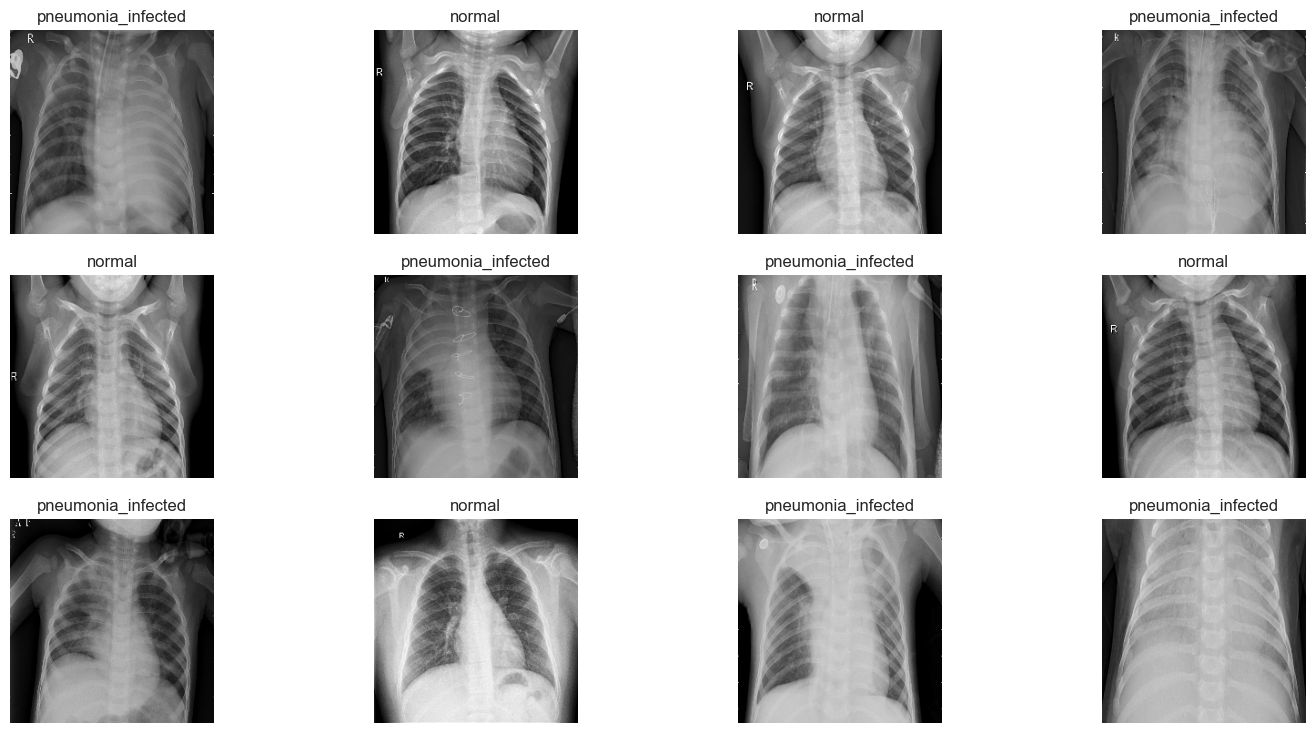

In [5]:
plt.figure(figsize= (18, 9))
for imageBatch, labelBatch in datasets.take(1):
    for i in range(12):
        ax= plt.subplot(3, 4, i+1)
        plt.imshow(imageBatch[i].numpy().astype("uint8"))
        plt.title(datasets.class_names[labelBatch[i]])
        plt.axis("off")

In [6]:
def getSplittedDS(ds, trainSplit= 0.8, testSplit= 0.1, valSplit= 0.1, shuffle= True, shuffleSize= 10000):
    assert (trainSplit + testSplit + valSplit) == 1
    
    dsSize= len(ds)
    
    if shuffle:
        ds= ds.shuffle(shuffleSize, seed= 12)
        
    trainSize= int(trainSplit*dsSize)
    valSize= int(valSplit*dsSize)
    
    trainDS= ds.take(trainSize)
    valDS= ds.skip(trainSize).take(valSize)
    testDS= ds.skip(trainSize).skip(valSize)
    
    return trainDS, valDS, testDS

In [7]:
trainDS, valDS, testDS= getSplittedDS(datasets)

In [8]:
len(datasets)

85

In [9]:
trainDS= trainDS.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
testDS= testDS.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
valDS= valDS.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)

In [10]:
dataAugmentation= tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomContrast(0.2)
])

In [22]:
resizeRescale= tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(imgSize, imgSize),
    layers.experimental.preprocessing.Rescaling(1/255)
])

In [23]:
trainDS= trainDS.map(lambda x, y: (dataAugmentation(x, training= True), y)).prefetch(buffer_size= tf.data.AUTOTUNE)

In [24]:
inpShape= (batchSize, imgSize, imgSize, rgbChannels)

model= models.Sequential([
    resizeRescale,
    dataAugmentation,
    layers.Conv2D(72, (3, 3), input_shape= inpShape, activation= 'relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation= 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation= 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation= 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation= 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation= 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(96, activation= 'sigmoid'),
    layers.Dropout(0.2),
    layers.Dense(len(clsNames), activation= 'softmax')
])

model.build(input_shape=inpShape)

In [25]:
model.compile(optimizer= 'adam', loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits= False), metrics= ['accuracy'])

In [26]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (32, 224, 224, 3)         0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (32, 224, 224, 72)        2016      
                                                                 
 max_pooling2d_12 (MaxPoolin  (32, 112, 112, 72)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (32, 110, 110, 64)        41536     
                                                                 
 max_pooling2d_13 (MaxPoolin  (32, 55, 55, 64)         0         
 g2D)                                                 

In [28]:
history= model.fit(trainDS, batch_size=batchSize, validation_data= valDS, verbose= 1, epochs= EPOCHS)

Epoch 1/100
68/68 [==============================] - 29s 410ms/step - loss: 0.2775 - accuracy: 0.8890 - val_loss: 0.2266 - val_accuracy: 0.9062
Epoch 2/100
68/68 [==============================] - 28s 406ms/step - loss: 0.2566 - accuracy: 0.8993 - val_loss: 0.2655 - val_accuracy: 0.9023
Epoch 3/100
68/68 [==============================] - 28s 403ms/step - loss: 0.2555 - accuracy: 0.9034 - val_loss: 0.2374 - val_accuracy: 0.9062
Epoch 4/100
68/68 [==============================] - 28s 404ms/step - loss: 0.2419 - accuracy: 0.9039 - val_loss: 0.2482 - val_accuracy: 0.9062
Epoch 5/100
68/68 [==============================] - 28s 403ms/step - loss: 0.2116 - accuracy: 0.9146 - val_loss: 0.2548 - val_accuracy: 0.9141
Epoch 6/100
68/68 [==============================] - 28s 405ms/step - loss: 0.2403 - accuracy: 0.9067 - val_loss: 0.2636 - val_accuracy: 0.9062
Epoch 7/100
68/68 [==============================] - 28s 405ms/step - loss: 0.2177 - accuracy: 0.9090 - val_loss: 0.1988 - val_accuracy:

In [30]:
score= model.evaluate(testDS.take(1))

1/1 [==============================] - 0s 364ms/step - loss: 0.0883 - accuracy: 1.0000


In [31]:
acc= history.history['accuracy']
valAccuracy= history.history['val_accuracy']

loss= history.history['loss']
valLoss= history.history['val_loss']

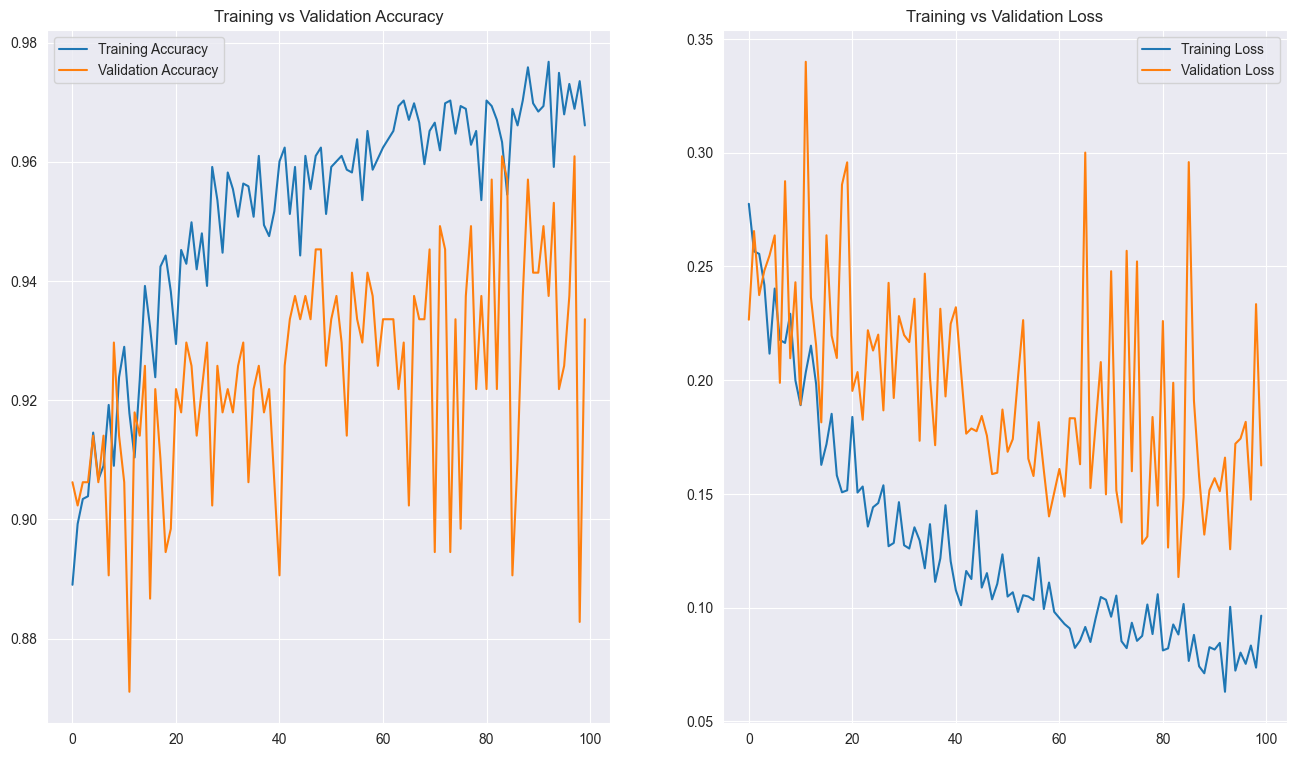

In [32]:
plt.figure(figsize= (16, 9))
plt.subplot(1, 2, 1)
sns.lineplot(x= range(EPOCHS), y=acc, label= 'Training Accuracy')
plt.title('Training vs Validation Accuracy')
sns.lineplot(x= range(EPOCHS), y=valAccuracy, label= 'Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
sns.lineplot(x= range(EPOCHS), y=loss, label= 'Training Loss')
plt.title('Training vs Validation Loss')
sns.lineplot(x= range(EPOCHS), y=valLoss, label= 'Validation Loss')
plt.legend()
plt.show()

In [33]:
def predFunc(model, img):
    imgArray= tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    imgArray= tf.expand_dims(imgArray, 0)
    
    predictions= model.predict(imgArray)
    
    predictedClass= clsNames[np.argmax(predictions[0])]
    confidence= round((100*(np.max(predictions[0]))), 2)
    
    return predictedClass, confidence

1/1 [==============================] - 0s 35ms/step


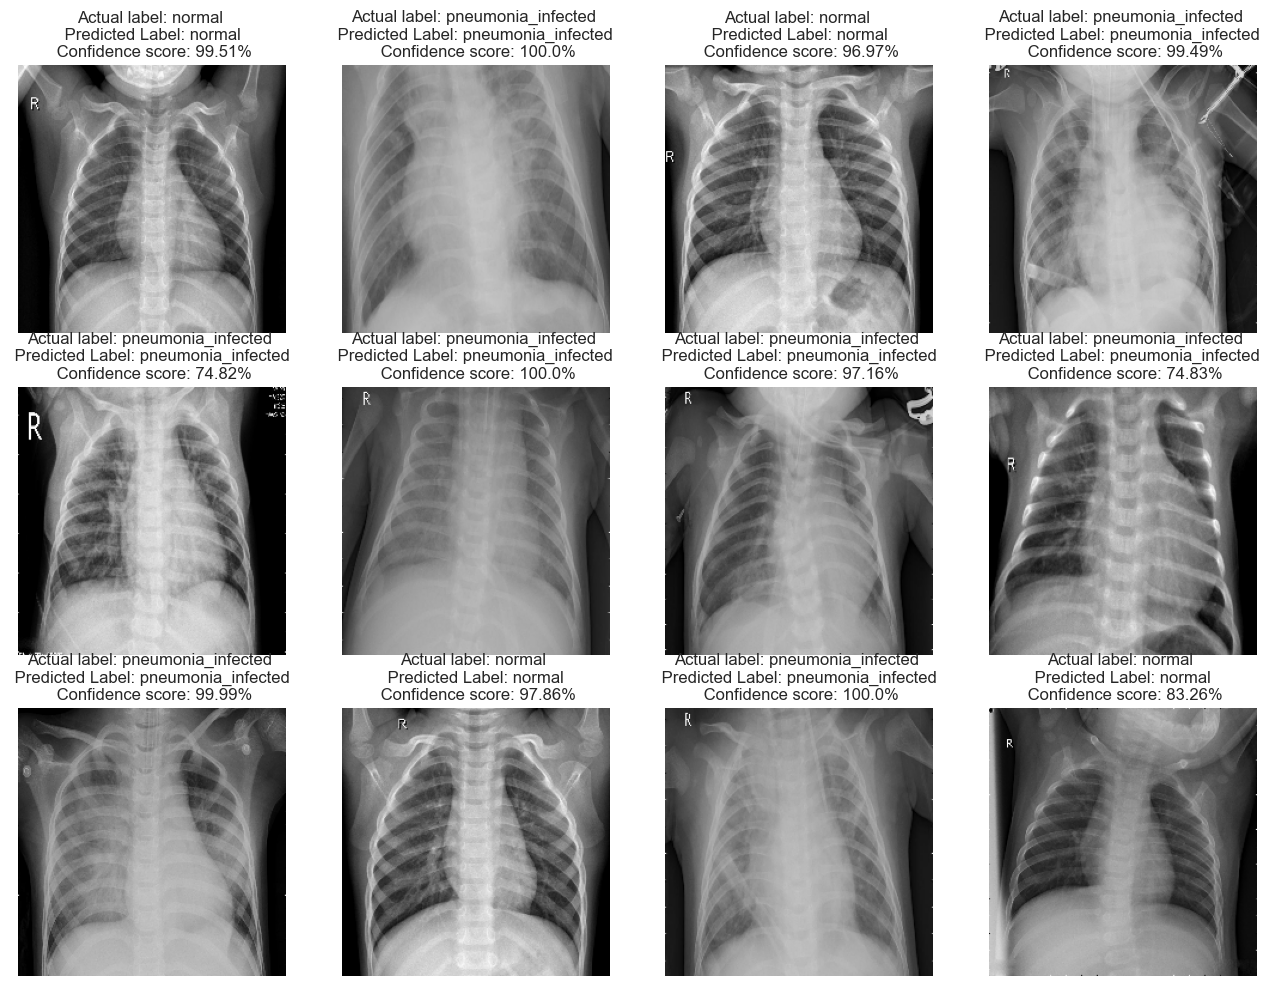

In [41]:
plt.figure(figsize= (16, 16))


for images, labels in testDS.take(1):
    for i in range(12):
        ax= plt.subplot(4, 4, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predictedCls, confidence= predFunc(model, images[i].numpy())
        actualCls= clsNames[labels[i]]
                
        plt.title(f"Actual label: {actualCls} \n Predicted Label: {predictedCls} \n Confidence score: {confidence}%")        
        plt.axis('off')

In [36]:
converter= tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model= converter.convert()

with open('../exports/pneumoniaV3.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Rohan\AppData\Local\Temp\tmpz2tnhuya\assets


INFO:tensorflow:Assets written to: C:\Users\Rohan\AppData\Local\Temp\tmpz2tnhuya\assets
